In [ ]:
# -*- coding: utf-8 -*
import keras
print(keras.__version__)

In [7]:
import imp
from operator import truediv
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tensorflow.python.keras import layers
#from keras.utils.image_utils import img_to_array, load_img, array_to_img
#from keras.datasets import mnist
from keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.models import Model
from sklearn.model_selection import train_test_split
from PIL import Image

In [ ]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
# 画像の読み込みパート

seed = 1
img_height = 1024
img_width = 1024
batch_size = 8

params = {
    # 'rotation_range': 180,
    'horizontal_flip' : False,
    'vertical_flip' : False,
    'rescale': 1.0 / 255,
    'validation_split': 0.5,
}
#optimizer = Adam(lr=0.001)
steps_per_epochs = 36000/batch_size
validation_steps = 4000/batch_size

datagen = ImageDataGenerator(**params)

X_path = "D:/kobayashi/M2/temp/X_train"

X_train_directory = datagen.flow_from_directory(
    directory = X_path, target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, seed=seed, subset='training',
)

y_path = "D:/kobayashi/M2/temp/y_train"

y_train_directory = datagen.flow_from_directory(
    directory = y_path, target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, subset='training',
)

train_zip = zip(X_train_directory, y_train_directory)

X_valid_directory = datagen.flow_from_directory(
    directory = X_path, target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, seed=seed, subset='validation'
)

y_valid_directory = datagen.flow_from_directory(
    directory = y_path, target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, subset='validation'
) 

valid_zip = zip(X_valid_directory, y_valid_directory)


# 4つのplotを表示
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(X_train_directory.next()[0], cmap='gray')
ax[0, 0].set_title('X_train')
ax[1, 0].imshow(y_train_directory.next()[0], cmap='gray')
ax[1, 0].set_title('y_train')
ax[0, 1].imshow(X_valid_directory.next()[0], cmap='gray')
ax[0, 1].set_title('X_valid')
ax[1, 1].imshow(y_valid_directory.next()[0], cmap='gray')
ax[1, 1].set_title('y_valid')
plt.show()


In [ ]:
# モデル構築パート

input = layers.Input(shape=(img_height, img_width, 1))

x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)


autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()


autoencoder.fit(
    x=train_zip,
    epochs=3,
    batch_size=batch_size,
    shuffle=False, 
    validation_data=valid_zip,     
    steps_per_epoch=steps_per_epochs,
    validation_steps=validation_steps,
)

Found 1 images belonging to 1 classes.
1/1 [==============================] - 0s 278ms/step


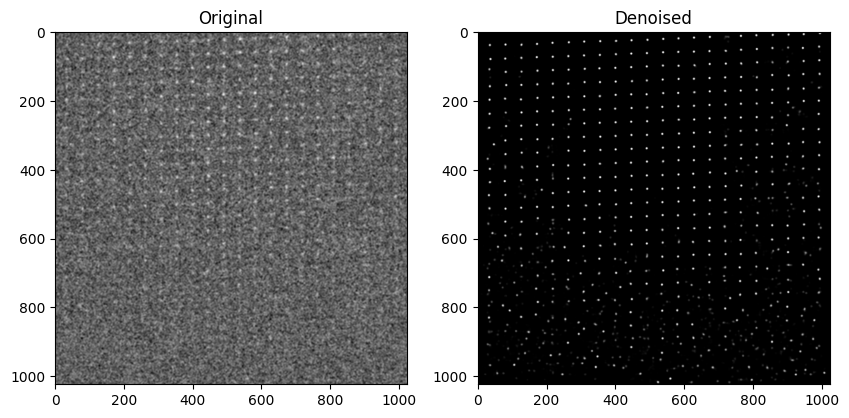

In [9]:
# モデルの読み込み
autoencoder = tf.keras.models.load_model("D:/kobayashi/M2/CNN_denoising1024_ep75_filter7")

# 実験画像でのテスト
predict_test_data = datagen.flow_from_directory(
    directory = "D:/kobayashi/M2/temp/X_test", target_size = (img_height, img_width), color_mode='grayscale', 
    class_mode=None, batch_size=batch_size, shuffle=None, seed=seed
)

predictions = autoencoder.predict(predict_test_data)

# 2つのplotを表示
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(predict_test_data.next()[0], cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(predictions[0], cmap='gray')
ax[1].set_title('Denoised') 
plt.show()